# Settings

In [115]:
Hot_encode_years = False

# Create dp_years_since_first_r, dp_years_since_last_r
Create_dp_years_since_vars = True

Drop_years_variables = True

Drop_current_status = True

# Libraries and dependencies

In [2]:
# Libraries and dependencies

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import math
from sklearn.metrics import accuracy_score
from google.colab import files
from sqlalchemy import create_engine
import psycopg2

## Import for models
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import re

# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Open Proxy to database

In [4]:
# Google Cloud SQL connexion:
# Code taken from: https://stackoverflow.com/questions/53180140/how-to-access-cloud-sql-from-google-colab
!gcloud auth login
!gcloud config set project endeavor-intelligence-unit
!gcloud sql instances describe finalprojectdb


Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=K5c1VcX3bgqXJTFmovEAaO8MGnn0Mg&prompt=consent&access_type=offline&code_challenge=flt9nPUH59IzaxD1KdgrHzNtKbXsaxZorCOwmlbCRP8&code_challenge_method=S256

Enter verification code: 4/1AX4XfWiJX7egriZ2rIySs3P9VquUG0VLZoKqG2uWlTd7KuLYd5qTG5A5lK4

You are now logged in as [lfbanos@gmail.com].
Your current project is [endeavor-intelligence-unit].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].
ERROR: (gcloud.sql.instances.describe)

In [5]:
# download and initialize the psql proxy
!wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
!chmod +x cloud_sql_proxy

# "connectionName" is from the previous block
!nohup ./cloud_sql_proxy -instances="endeavor-intelligence-unit:northamerica-northeast2:finalprojectdb"=tcp:5432 &
!sleep 30s

--2021-11-21 21:29:58--  https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64
Resolving dl.google.com (dl.google.com)... 173.194.216.91, 173.194.216.93, 173.194.216.190, ...
Connecting to dl.google.com (dl.google.com)|173.194.216.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16638816 (16M) [application/octet-stream]
Saving to: ‘cloud_sql_proxy’

cloud_sql_proxy     100%[===================>]  15.87M  --.-KB/s    in 0.06s   

2021-11-21 21:29:58 (247 MB/s) - ‘cloud_sql_proxy’ saved [16638816/16638816]

nohup: appending output to 'nohup.out'


In [6]:
#Checking the proxy´s logs 
!cat nohup.out

2021/11/21 16:34:18 current FDs rlimit set to 1048576, wanted limit is 8500. Nothing to do here.
2021/11/21 16:34:20 errors parsing config:
	googleapi: Error 403: The client is not authorized to make this request., notAuthorized
2021/11/21 21:29:59 current FDs rlimit set to 1048576, wanted limit is 8500. Nothing to do here.
2021/11/21 21:30:00 errors parsing config:
	googleapi: Error 403: The client is not authorized to make this request., notAuthorized


# Get Companies Data

In [7]:
# Connexion throught psycopg2 Google Cloud SQL data base
conn = psycopg2.connect(
    host='34.130.143.207', port='5432', database="data_investments",
    user="postgres", password="zgHqczD17IDyeSQL")

In [8]:
# Query to connect with SQL data base
SQL_Query = pd.read_sql_query('''select * FROM "companies" ''', conn)
companies_df = pd.DataFrame(SQL_Query)

In [9]:
conn.close()

# Cleaning

In [116]:
# Drop the null columns where all values are null
companies_clean_df = companies_df.dropna(axis='columns', how='all')

In [117]:
print("Number of columns, features and result variables:", len(companies_clean_df.columns))

Number of columns, features and result variables: 68


In [118]:
for col in companies_clean_df.columns:
  print(col)

id_company
foundation_year
category
first_r_year
first_r_amount
last_funding_year
amount_last_funding
month_since_last_funding
number_employees
increase_employees
number_investors
current_status
rounds_funding_factor
soonicorn
more50_employees
more100_employees
dp_year
dp_rounds_count
dp_rounds_amount_sum
dp_rounds_amount_max
dp_last_round_year
dp_last_round_amount
dp_years_operating
max_manager_exp
max_clevel_exp
max_engineering_exp
max_sales_exp
max_finance_exp
max_human_capital_exp
max_consulting_exp
max_founder_exp
max_number_of_startups
max_gender
max_foreing_studies
max_foreing_work_experience
max_foreing_founder
max_dp_years_of_experience
max_dp_years_of_experience_as_entreprenuer
sum_manager_exp
sum_clevel_exp
sum_engineering_exp
sum_sales_exp
sum_finance_exp
sum_human_capital_exp
sum_consulting_exp
sum_founder_exp
sum_number_of_startups
sum_gender
sum_foreing_studies
sum_foreing_work_experience
sum_foreing_founder
sum_dp_years_of_experience
sum_dp_years_of_experience_as_entrep

# Features Correction

In [119]:
# Define Function
def fnc_dp_year(dp_year,foundation_year):
  if ( dp_year > 0 ):
    return dp_year
  else:
    return foundation_year

In [120]:
fnc_dp_year(1.00,2014.00)

1.0

In [121]:
companies_clean_df['dp_year'] = companies_clean_df.apply(lambda x: fnc_dp_year(x['dp_year'],x['foundation_year']),axis=1)

In [122]:
companies_clean_df['dp_year']

0      2017.0
1      2018.0
2      2015.0
3      2021.0
4      2018.0
        ...  
505    2021.0
506    2021.0
507    2021.0
508    2021.0
509    2021.0
Name: dp_year, Length: 510, dtype: float64

In [123]:
companies_clean_df['dp_last_round_year'] = companies_clean_df.apply(lambda x: x['dp_last_round_year'] if (x['dp_last_round_year']>0) else x['foundation_year'],axis=1)

# Features Creation

In [124]:
if (Create_dp_years_since_vars):
  # companies_clean_df['dp_years_since_foundation'] = companies_clean_df['dp_year'] - companies_clean_df['foundation_year']
  companies_clean_df['dp_years_since_first_r'] = companies_clean_df['dp_year'] - companies_clean_df['first_r_year']
  companies_clean_df['dp_years_since_last_r'] = companies_clean_df['dp_year'] - companies_clean_df['dp_last_round_year']
    

# Feature selection

In [125]:
# Create de list for drop columns from Models
columnsName = companies_clean_df.columns.tolist()

# Mean and max columns are droped as they are very correlated to sum (we keep only sum experience)
r = re.compile("^mean|^max")
columnsName = [column for column in columnsName if r.match(column)]

other_cols_to_drop = [
              "last_funding_year",
              "amount_last_funding",
              "month_since_last_funding",
              "number_employees",
              "increase_employees",
              "number_investors",
              # "soonicorn",
              # "more50_employees",
              # "more100_employees",  
]

columnsName.extend(other_cols_to_drop)

if (Drop_years_variables):
  other_cols_to_drop = [
    'foundation_year',
    'first_r_year',
    'dp_last_round_year',
    'dp_year'
  ]
  columnsName.extend(other_cols_to_drop)


if (Drop_current_status):
  other_cols_to_drop = [
    'current_status'
  ]
  columnsName.extend(other_cols_to_drop)
  
for column in columnsName:
  companies_clean_df.drop(column, axis='columns', inplace=True)
  
print("Number of columns, features and result variables:", len(companies_clean_df.columns))
companies_clean_df.head()



Number of columns, features and result variables: 29


,id_company,category,first_r_amount,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,dp_years_since_first_r,dp_years_since_last_r
0,3.0,0.0,1400000.0,4.0,0.0,0.0,0.0,1.0,1400000.0,1400000.0,1400000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,1.0,0.0,0.0,22.0,15.0,0.0,0.0
1,7.0,0.0,10500.0,3.0,0.0,0.0,0.0,1.0,10500.0,10500.0,10500.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0,0.0,0.0
2,10.0,0.0,200000.0,6.0,0.0,0.0,0.0,1.0,200000.0,200000.0,200000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0
3,23.0,0.0,150000.0,0.0,1.0,1.0,1.0,5.0,54800000.0,40000000.0,40000000.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0,8.0,0.0
4,51.0,0.0,20000.0,3.0,0.0,0.0,0.0,1.0,20000.0,20000.0,20000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0


In [126]:
# Companies clean with y
companies_clean_with_y = companies_clean_df

In [127]:
# Companies clean without y

companies_clean_without_y = companies_clean_df.copy()

y_cols = [
            "soonicorn",
            "more50_employees",
            "more100_employees",  
]

for col in y_cols:
  companies_clean_without_y.drop(col, axis='columns', inplace=True)

# Encode

In [128]:
# Copy dataframe
companies_encoded_df = companies_clean_without_y.copy()

In [129]:
companies_encoded_df

,id_company,category,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,dp_years_since_first_r,dp_years_since_last_r
0,3.0,0.0,1400000.0,4.0,1.0,1400000.0,1400000.0,1400000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,1.0,0.0,0.0,22.0,15.0,0.0,0.0
1,7.0,0.0,10500.0,3.0,1.0,10500.0,10500.0,10500.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0,0.0,0.0
2,10.0,0.0,200000.0,6.0,1.0,200000.0,200000.0,200000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0
3,23.0,0.0,150000.0,0.0,5.0,54800000.0,40000000.0,40000000.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0,8.0,0.0
4,51.0,0.0,20000.0,3.0,1.0,20000.0,20000.0,20000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,4429.0,0.0,750000.0,0.0,4.0,12510000.0,4960000.0,3100000.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,12.0,11.0,3.0,0.0
506,4433.0,0.0,225000000.0,0.0,1.0,225000000.0,225000000.0,225000000.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,9.0,8.0,0.0,0.0
507,4434.0,0.0,130000.0,0.0,1.0,130000.0,130000.0,130000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,6.0,4.0,0.0,0.0
508,4435.0,0.0,130000.0,0.0,1.0,130000.0,130000.0,130000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0


In [130]:
companies_encoded_df.loc[companies_encoded_df['id_company'] == 2233.0]

,id_company,category,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,dp_years_since_first_r,dp_years_since_last_r
240,2233.0,0.0,500000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:

# Encoding labels
le = LabelEncoder()

# Get the name of the columns
columnsName = companies_encoded_df.columns.tolist()

columnsName.remove('rounds_funding_factor')

r = re.compile("^mean")
columnsName = [column for column in columnsName if not r.match(column)]

# convert variables to numerical
for column in columnsName:
  companies_encoded_df[column] = pd.to_numeric(companies_encoded_df[column], errors='coerce').fillna(0).astype(np.int64)


In [132]:
print("Number of columns:", len(companies_encoded_df.columns))

Number of columns: 26


In [133]:
companies_encoded_df.loc[companies_encoded_df['id_company'] == 2233.0]

,id_company,category,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,dp_years_since_first_r,dp_years_since_last_r
240,2233,0,500000000,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0


In [134]:
# Copy the dataframe to new one, for create the models
#db_companies_Encode_Model = db_companies_Encode.copy()
#db_companies_Encode_Model.head()

In [135]:
# Generate our categorical variable lists
db_companies_cat = ["foundation_year","category","first_r_year","dp_year","current_status","dp_last_round_year"] 
db_companies_cat

['foundation_year',
 'category',
 'first_r_year',
 'dp_year',
 'current_status',
 'dp_last_round_year']

In [136]:
db_companies_cat_corrected = []

for cat in db_companies_cat:
  if cat in companies_encoded_df.columns:
    db_companies_cat_corrected.append(cat)

db_companies_cat = db_companies_cat_corrected

In [137]:
db_companies_cat_corrected

['category']

In [138]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(companies_encoded_df[db_companies_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(db_companies_cat)

# Merge one-hot encoded features and drop the originals
companies_encoded_df = companies_encoded_df.merge(encode_df,left_index=True, right_index=True)
companies_encoded_df = companies_encoded_df.drop(db_companies_cat,1)

# Create de list for drop columns from Models
columnsName = companies_encoded_df.columns.tolist()
columnsName.remove('rounds_funding_factor')

# convert variables to numerical
for column in columnsName:
  companies_encoded_df[column] = pd.to_numeric(companies_encoded_df[column], errors='coerce').fillna(0).astype(np.int64)

In [139]:
print(companies_encoded_df.dtypes)

id_company                                      int64
first_r_amount                                  int64
rounds_funding_factor                         float64
dp_rounds_count                                 int64
dp_rounds_amount_sum                            int64
dp_rounds_amount_max                            int64
dp_last_round_amount                            int64
dp_years_operating                              int64
sum_manager_exp                                 int64
sum_clevel_exp                                  int64
sum_engineering_exp                             int64
sum_sales_exp                                   int64
sum_finance_exp                                 int64
sum_human_capital_exp                           int64
sum_consulting_exp                              int64
sum_founder_exp                                 int64
sum_number_of_startups                          int64
sum_gender                                      int64
sum_foreing_studies         

In [140]:
only_companies_id_df = companies_encoded_df[['id_company']]

In [141]:
companies_encoded_df = companies_encoded_df.drop('id_company', axis='columns', inplace=False)

In [142]:
companies_encoded_df

,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,dp_years_since_first_r,dp_years_since_last_r,category_0
0,1400000,4.0,1,1400000,1400000,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0,0,1
1,10500,3.0,1,10500,10500,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,0,0,1
2,200000,6.0,1,200000,200000,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,0,0,1
3,150000,0.0,5,54800000,40000000,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,8,0,1
4,20000,3.0,1,20000,20000,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,750000,0.0,4,12510000,4960000,3100000,3,1,1,0,1,0,0,1,1,1,1,1,1,0,12,11,3,0,1
506,225000000,0.0,1,225000000,225000000,225000000,0,0,1,0,0,1,0,1,1,1,1,1,0,1,9,8,0,0,1
507,130000,0.0,1,130000,130000,130000,0,0,0,1,0,0,0,0,1,2,1,1,0,0,6,4,0,0,1
508,130000,0.0,1,130000,130000,130000,0,0,0,0,0,0,0,0,1,2,1,1,0,0,3,3,0,0,1


# Mahalanobis distance

In [143]:
# Source: https://www.youtube.com/watch?v=4buOoXp7AyI

In [144]:
data = companies_encoded_df.to_numpy()

In [145]:
data

array([[1.40e+06, 4.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [1.05e+04, 3.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [2.00e+05, 6.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       ...,
       [1.30e+05, 0.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [1.30e+05, 0.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [4.90e+06, 0.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00]])

In [146]:
def fnc_mahalanobis(data,index):

  x = data[index]

  data_del = np.delete(data,index,0)

  m = np.mean(data_del,axis=0)

  xMm = x - m

  data_transposed = np.transpose(data_del)
  covM = np.cov(data_transposed,bias=False)
  invCoveM = np.linalg.pinv(covM)

  tem1 = np.dot(xMm,invCoveM)
  tem2 = np.dot(tem1,np.transpose(xMm))

  # print(tem1)
  # print(tem2)
  
  MD = np.sqrt(tem2)

  return MD



In [147]:
fnc_mahalanobis(data,0)

1.7957864161971122

In [148]:
mahalanobis = []
my_range = range(len(data))

my_range

range(0, 510)

In [149]:
mahalanobis = []

for i in range(len(data)):
  mahalanobis.append(fnc_mahalanobis(data,i))

# mahalanobis

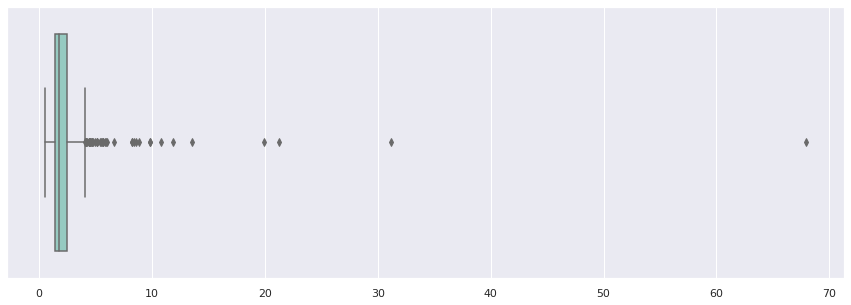

In [150]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(x=mahalanobis, palette="Set3")

In [151]:
companies_clean_mahalanobis_df = companies_clean_with_y.copy()

In [152]:
companies_clean_mahalanobis_df["mahalanobis"]=mahalanobis

In [153]:
companies_clean_mahalanobis_df[companies_clean_mahalanobis_df["mahalanobis"]>5].sort_values(by=["mahalanobis"],ascending=False)

,id_company,category,first_r_amount,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,dp_years_since_first_r,dp_years_since_last_r,mahalanobis
240,2233.0,0.0,500000000.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,67.945744
269,2390.0,0.0,1517450.0,0.0,1.0,1.0,1.0,6.0,232017450.0,79000000.0,55000000.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0,0.0,4.0,0.0,31.134075
334,3018.0,0.0,82000000.0,0.0,1.0,1.0,1.0,2.0,96000000.0,82000000.0,14000000.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,17.0,14.0,1.0,0.0,21.288498
506,4433.0,0.0,225000000.0,0.0,1.0,1.0,1.0,1.0,225000000.0,225000000.0,225000000.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,9.0,8.0,0.0,0.0,19.885766
392,3523.0,0.0,50000000.0,3.0,1.0,0.0,0.0,2.0,50250000.0,50000000.0,250000.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,9.0,2.0,1.0,0.0,13.520907
235,2200.0,0.0,3280000.0,0.0,1.0,1.0,1.0,3.0,175280000.0,162000000.0,162000000.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,15.0,10.0,3.0,0.0,11.833254
18,219.0,0.0,8470000.0,3.0,0.0,1.0,0.0,2.0,8795000.0,8470000.0,325000.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,3.0,1.0,1.0,0.0,55.0,7.0,2.0,0.0,10.833995
78,781.0,0.0,1700000.0,0.0,1.0,1.0,1.0,6.0,54330000.0,40900000.0,2180000.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,27.0,9.0,4.0,0.0,9.819419
162,1507.0,0.0,12000000.0,0.0,1.0,1.0,0.0,3.0,126000000.0,57000000.0,57000000.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,9.801980
35,358.0,0.0,112000000.0,4.0,1.0,1.0,1.0,1.0,112000000.0,112000000.0,112000000.0,0.0,2.0,3.0,1.0,2.0,1.0,0.0,2.0,0.0,4.0,3.0,1.0,2.0,1.0,17.0,28.0,0.0,0.0,8.855295


# Drop outliers from companies_encoded_df

In [154]:
outliers_limit = 70


In [155]:
def drop_mahalanobis_outliers(df_encoded,df_mahalanobis,limit):
  df_outliers = df_mahalanobis[df_mahalanobis["mahalanobis"]>limit].sort_values(by=["mahalanobis"],ascending=False)

  df_encoded_wo_outliers = df_encoded.copy()

  for index, row in df_outliers.iterrows():
    # print(index)
    df_encoded_wo_outliers.drop(index=index,inplace=True)
  
  return df_encoded_wo_outliers
  


In [156]:
companies_encoded_wo_outliers = drop_mahalanobis_outliers(companies_encoded_df,companies_clean_mahalanobis_df,outliers_limit)
companies_encoded_wo_outliers

,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,dp_years_since_first_r,dp_years_since_last_r,category_0
0,1400000,4.0,1,1400000,1400000,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0,0,1
1,10500,3.0,1,10500,10500,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,0,0,1
2,200000,6.0,1,200000,200000,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,0,0,1
3,150000,0.0,5,54800000,40000000,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,8,0,1
4,20000,3.0,1,20000,20000,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,750000,0.0,4,12510000,4960000,3100000,3,1,1,0,1,0,0,1,1,1,1,1,1,0,12,11,3,0,1
506,225000000,0.0,1,225000000,225000000,225000000,0,0,1,0,0,1,0,1,1,1,1,1,0,1,9,8,0,0,1
507,130000,0.0,1,130000,130000,130000,0,0,0,1,0,0,0,0,1,2,1,1,0,0,6,4,0,0,1
508,130000,0.0,1,130000,130000,130000,0,0,0,0,0,0,0,0,1,2,1,1,0,0,3,3,0,0,1


# PCA Scenarios

- Multiple scenarios analisys
- Dropping outliers in different limits (70 (none), 40, 30, 15, 7, 5)
- Range of number of components from 2 to 30

In [157]:


components_range = range(2,24)

In [158]:
def fnc_get_pca_explained_variance_df(df_in,components_range):
  # Standarize data with StandarScaler
  df_scaled = StandardScaler().fit_transform(df_in)

  pca_list = []

  for components in components_range:

    # Initialize PCA model
    pca = PCA(n_components=components)

    # Get principal components
    pca_ndarray = pca.fit_transform(df_scaled)

    # Fetch the explained variance
    # print(pca.explained_variance_ratio_)
    # print(sum(pca.explained_variance_ratio_))

    pca_list.append(sum(pca.explained_variance_ratio_))

  explained_variance_df = pd.DataFrame({'components':components_range,'explained_variance':pca_list})
  explained_variance_df.set_index(['components'],inplace=True)
  
  # print pca_list at the end
  return explained_variance_df

In [159]:
outliers_limit_list = [70,40,30,15,7,5]
# outliers_limit_list = [70]

In [160]:
# clean  explained_variance_escenarios_df
explained_variance_escenarios_df = pd.DataFrame()

for outliers_limit in outliers_limit_list:
  companies_encoded_wo_outliers_df = drop_mahalanobis_outliers(companies_encoded_df,companies_clean_mahalanobis_df,outliers_limit)

  print(f"limit_{outliers_limit}:",len(companies_encoded_wo_outliers_df.index))
  
  explained_variance_df = fnc_get_pca_explained_variance_df(companies_encoded_wo_outliers_df,components_range)

  explained_variance_escenarios_df[[f"limit_{outliers_limit}"]] = explained_variance_df[['explained_variance']]

# Print explained_variance_escenarios_df
explained_variance_escenarios_df

limit_70: 510
limit_40: 509
limit_30: 508
limit_15: 506
limit_7: 496
limit_5: 484


,limit_70,limit_40,limit_30,limit_15,limit_7,limit_5
components,,,,,,
2,0.359230,0.371821,0.374739,0.371054,0.369944,0.359099
3,0.465401,0.484317,0.487874,0.481102,0.466504,0.460974
4,0.528773,0.547760,0.551334,0.544732,0.531205,0.527412
5,0.579356,0.598393,0.601748,0.595047,0.585279,0.581740
6,0.627176,0.646290,0.649610,0.643137,0.633532,0.630758
7,0.671706,0.690588,0.693941,0.686714,0.676909,0.675831
8,0.713340,0.732338,0.735494,0.728887,0.718368,0.718394
9,0.749934,0.767652,0.770900,0.764387,0.756250,0.755170
10,0.785218,0.802687,0.805877,0.799355,0.791227,0.790540


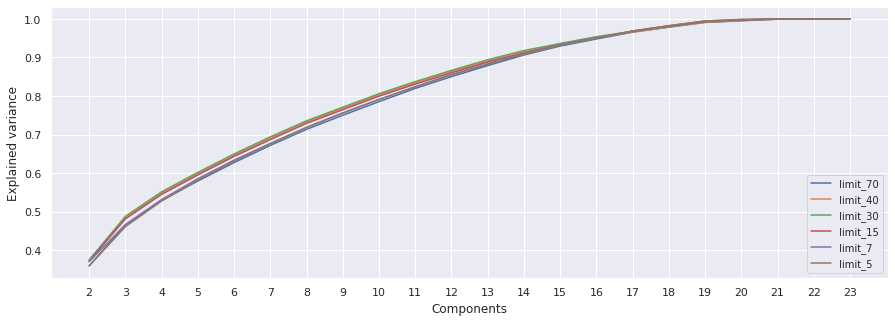

In [161]:
# Plot explained_variance_escenarios_df

cols_list = explained_variance_escenarios_df.columns
# ['limit_70',	'limit_40',	'limit_30',	'limit_15',	'limit_7',	'limit_5']

plt.figure(figsize=(15,5))

for col in cols_list:
  plt.plot(explained_variance_escenarios_df.index, explained_variance_escenarios_df[[col]],label = col)

# plt.plot(explained_variance_escenarios_df.index, explained_variance_escenarios_df[['limit_40']],label = 'limit_40')
# plt.plot(explained_variance_escenarios_df.index, explained_variance_escenarios_df[['limit_30']],label = 'limit_30')
# plt.plot(explained_variance_escenarios_df.index, explained_variance_escenarios_df[['limit_15']],label = 'limit_15')
# plt.plot(explained_variance_escenarios_df.index, explained_variance_escenarios_df[['limit_7']],label = 'limit_7')
# plt.plot(explained_variance_escenarios_df.index, explained_variance_escenarios_df[['limit_5']],label = 'limit_5')

plt.xticks(explained_variance_escenarios_df.index)
plt.xlabel('Components')
plt.ylabel('Explained variance')
plt.legend(loc='lower right', prop= {'size':10})

plt.show()

# PCA Selected Scenario

In [162]:
outliers_limit = 70
df_companies_encoded_wo_outliers = drop_mahalanobis_outliers(companies_encoded_df,companies_clean_mahalanobis_df,outliers_limit)

In [163]:
# Standarize data with StandarScaler
companies_scaled = StandardScaler().fit_transform(df_companies_encoded_wo_outliers)

# without scaling:
# companies_scaled = companies_encoded_wo_outliers.to_numpy()

print(companies_scaled[0:2])

[[-0.07719457  0.55080271 -0.64885226 -0.25544559 -0.22296465 -0.19906116
  -0.6484767   0.59497429  0.25622998 -0.51160813 -0.32969024 -0.36938377
  -0.15817414 -0.51173869  1.48655153  1.2126927   1.38014783  0.58715482
  -0.73715445 -0.52795063  1.06454566  1.1652819  -0.6484767   0.
   0.        ]
 [-0.1314272   0.17424858 -0.64885226 -0.31625546 -0.30082007 -0.28043283
  -0.6484767   0.59497429  0.25622998 -0.51160813 -0.32969024 -0.36938377
  -0.15817414 -0.51173869  0.05067789  1.2126927  -0.1401014  -0.902641
  -0.73715445 -0.52795063 -0.23017203  0.34178014 -0.6484767   0.
   0.        ]]


In [164]:
components = 10

# Initialize PCA model
pca = PCA(n_components=components)

# Get principal components
companies_pca = pca.fit_transform(companies_scaled)

# Fetch the explained variance
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))


[0.22736479 0.13186484 0.1061711  0.06337574 0.05059188 0.04780862
 0.04453136 0.04163225 0.03659309 0.03528476]
0.7852184401854533


In [165]:
len(pca.components_[0])

25

In [166]:
# Transform PCA data to a DataFrame

# pca_column_names
pca_column_names = []
for i in range(1,(components+1)):
  pca_column_names.append(f"PC{i}")


df_companies_pca = pd.DataFrame(
    data=companies_pca,
    columns=pca_column_names
)

df_companies_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.713280,-1.820768,1.051593,-0.880335,-1.313363,-0.844358,0.692724,-0.551599,-0.067671,0.989141
1,-0.933142,-0.764833,0.402864,-0.149094,-1.115229,-0.174315,0.551768,-0.191078,-0.277613,0.546685
2,-1.841288,-0.394542,0.555595,0.039351,-0.873790,-0.104909,-0.250379,0.300178,-0.014519,0.242587
3,2.721751,5.220931,-3.266215,-0.447082,-0.259385,0.378302,0.796606,-1.118490,-0.395446,-0.065472
4,-1.988755,0.239630,0.185660,-0.709748,-0.374536,1.241307,-0.735510,0.612362,0.701488,-0.176834


# Running KMeans with PCA Data

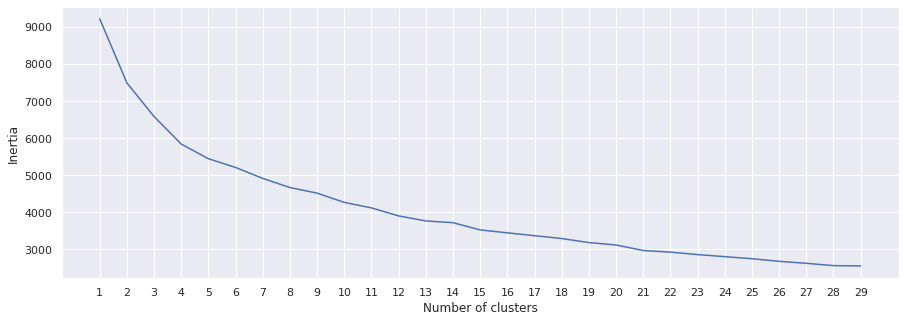

In [167]:
# Finding the best value for k
inertia = []
k = list(range(1, 30))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_companies_pca)
    inertia.append(km.inertia_)

# Creating the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [168]:
# Predicting clusters with 
k=5

# Initialize the k-means model
model = KMeans(n_clusters=k, random_state=0)

# Fit the model
model.fit(df_companies_pca)

# Predict clusters
predictions = model.predict(df_companies_pca)

# Add the predicted class column to the dataframe
df_companies_pca["class"] = model.labels_
df_companies_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,class
0,0.713280,-1.820768,1.051593,-0.880335,-1.313363,-0.844358,0.692724,-0.551599,-0.067671,0.989141,0
1,-0.933142,-0.764833,0.402864,-0.149094,-1.115229,-0.174315,0.551768,-0.191078,-0.277613,0.546685,0
2,-1.841288,-0.394542,0.555595,0.039351,-0.873790,-0.104909,-0.250379,0.300178,-0.014519,0.242587,4
3,2.721751,5.220931,-3.266215,-0.447082,-0.259385,0.378302,0.796606,-1.118490,-0.395446,-0.065472,1
4,-1.988755,0.239630,0.185660,-0.709748,-0.374536,1.241307,-0.735510,0.612362,0.701488,-0.176834,4


# Clusters Visualization

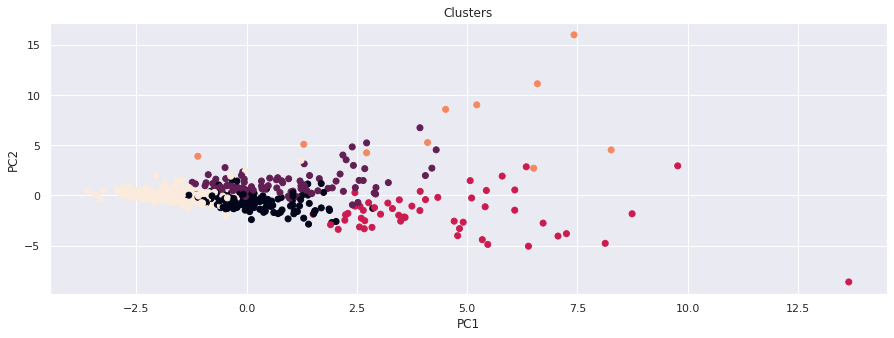

In [172]:
# Visualize the clusters
plt.scatter(x=df_companies_pca['PC1'], y=df_companies_pca['PC2'], c=df_companies_pca['class'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters')
plt.show()

In [173]:
import plotly.express as px

df = df_companies_pca
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
              color='class')
fig.show()

# K-means clustering with encoded data (without PCA)

In [203]:
# Standarize data with StandarScaler
companies_scaled = StandardScaler().fit_transform(df_companies_encoded_wo_outliers)
companies_scaled

array([[-0.07719457,  0.55080271, -0.64885226, ..., -0.6484767 ,
         0.        ,  0.        ],
       [-0.1314272 ,  0.17424858, -0.64885226, ..., -0.6484767 ,
         0.        ,  0.        ],
       [-0.12403095,  1.30391097, -0.64885226, ..., -0.6484767 ,
         0.        ,  0.        ],
       ...,
       [-0.12676307, -0.95541382, -0.64885226, ..., -0.6484767 ,
         0.        ,  0.        ],
       [-0.12676307, -0.95541382, -0.64885226, ..., -0.6484767 ,
         0.        ,  0.        ],
       [ 0.05941155, -0.95541382, -0.64885226, ..., -0.6484767 ,
         0.        ,  0.        ]])

In [204]:
df_companies_encoded_wo_outliers.columns.to_list()

['first_r_amount',
 'rounds_funding_factor',
 'dp_rounds_count',
 'dp_rounds_amount_sum',
 'dp_rounds_amount_max',
 'dp_last_round_amount',
 'dp_years_operating',
 'sum_manager_exp',
 'sum_clevel_exp',
 'sum_engineering_exp',
 'sum_sales_exp',
 'sum_finance_exp',
 'sum_human_capital_exp',
 'sum_consulting_exp',
 'sum_founder_exp',
 'sum_number_of_startups',
 'sum_gender',
 'sum_foreing_studies',
 'sum_foreing_work_experience',
 'sum_foreing_founder',
 'sum_dp_years_of_experience',
 'sum_dp_years_of_experience_as_entreprenuer',
 'dp_years_since_foundation',
 'dp_years_since_first_r',
 'dp_years_since_last_r',
 'category_0']

In [206]:
# data to a DataFrame

# pca_column_names
column_names = df_companies_encoded_wo_outliers.columns.to_list()

df_companies_pca = pd.DataFrame(
    data=companies_scaled,
    columns=column_names
)

df_companies_pca.head()

,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,dp_years_since_foundation,dp_years_since_first_r,dp_years_since_last_r,category_0
0,-0.077195,0.550803,-0.648852,-0.255446,-0.222965,-0.199061,-0.648477,0.594974,0.25623,-0.511608,-0.32969,-0.369384,-0.158174,-0.511739,1.486552,1.212693,1.380148,0.587155,-0.737154,-0.527951,1.064546,1.165282,-0.648477,-0.648477,0.0,0.0
1,-0.131427,0.174249,-0.648852,-0.316255,-0.300820,-0.280433,-0.648477,0.594974,0.25623,-0.511608,-0.32969,-0.369384,-0.158174,-0.511739,0.050678,1.212693,-0.140101,-0.902641,-0.737154,-0.527951,-0.230172,0.341780,-0.648477,-0.648477,0.0,0.0
2,-0.124031,1.303911,-0.648852,-0.307962,-0.290202,-0.269335,-0.648477,0.594974,0.25623,-0.511608,-0.32969,-0.369384,-0.158174,-0.511739,0.050678,-0.732192,-0.140101,-0.902641,-0.737154,-0.527951,-0.014386,-0.618972,-0.648477,-0.648477,0.0,0.0
3,-0.125982,-0.955414,1.797836,2.081544,1.939841,2.061426,4.059326,-0.929834,0.25623,-0.511608,-0.32969,-0.369384,-0.158174,-0.511739,0.050678,-0.083897,-0.140101,-0.902641,-0.737154,-0.527951,-0.122279,-0.344471,4.059326,4.059326,0.0,0.0
4,-0.131056,0.174249,-0.648852,-0.315840,-0.300288,-0.279876,-0.648477,-0.929834,0.25623,1.609694,-0.32969,-0.369384,-0.158174,-0.511739,-1.385196,-0.732192,-0.140101,0.587155,-0.737154,-0.527951,-0.769638,-0.893472,-0.648477,-0.648477,0.0,0.0


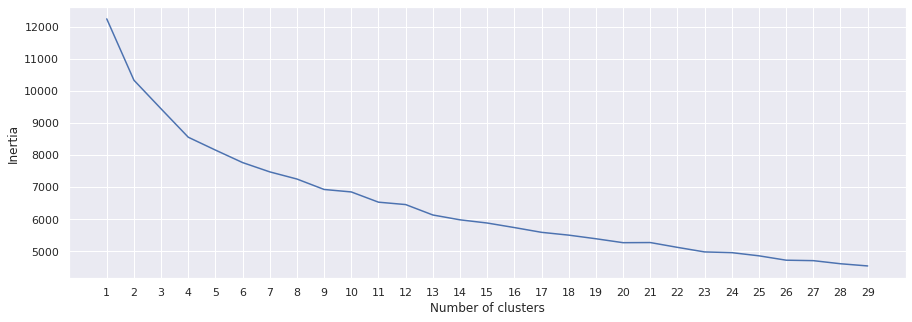

In [207]:
# Finding the best value for k
inertia = []
k = list(range(1, 30))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_companies_pca)
    inertia.append(km.inertia_)

# Creating the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Y by cluster

In [179]:
df_Y_by_cluster = df_companies_pca[["class"]]
df_Y_by_cluster['soonicorn'] = companies_clean_with_y['soonicorn']
df_Y_by_cluster['more50_employees'] = companies_clean_with_y['more50_employees']
df_Y_by_cluster['more100_employees'] = companies_clean_with_y['more100_employees']
df_Y_by_cluster

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,class,soonicorn,more50_employees,more100_employees
0,0,0.0,0.0,0.0
1,0,0.0,0.0,0.0
2,4,0.0,0.0,0.0
3,1,1.0,1.0,1.0
4,4,0.0,0.0,0.0
...,...,...,...,...
505,1,0.0,1.0,1.0
506,3,1.0,1.0,1.0
507,4,0.0,0.0,0.0
508,4,0.0,0.0,0.0


In [183]:
df_Y_by_cluster_grouped = df_Y_by_cluster.groupby(by=['class']).sum()
df_Y_by_cluster_grouped

,soonicorn,more50_employees,more100_employees
class,,,
0,6.0,25.0,11.0
1,8.0,38.0,25.0
2,13.0,23.0,17.0
3,10.0,10.0,9.0
4,5.0,23.0,11.0


In [186]:
import plotly.express as px
df = df_Y_by_cluster
fig = px.bar(df, x="class", y="soonicorn", color="class")
fig.show()

In [187]:
import plotly.express as px
df = df_Y_by_cluster
fig = px.bar(df, x="class", y="more50_employees", color="class")
fig.show()

In [188]:
import plotly.express as px
df = df_Y_by_cluster
fig = px.bar(df, x="class", y="more100_employees", color="class")
fig.show()